# Playground datasets train on local computer (I)
&emsp;&emsp;基于`playground`的4种样例数据集，尝试在本机训练DNN模型进行二分类问题。由于4个分类问题对于模型规模和具体参数选择略有不同，将以下4个问题分别进行探讨：
+ <b>circle data</b>
+ gauss data
+ xor data
+ spiral data
<img src="img/dataset_subplots.png" height="50%" width="50%">

&emsp;&emsp;本文档针对第一个数据集。在模型训练过程中，从数据生成过程到模型构建和相关参数的选择，均能够在`playground`上得到实现。当然，tensorflow的功能远远更为强大。在尽量保持与`playground`结果可比的基础上，尽可能在tensorflow上获得不劣于`playground`的结果。

&emsp;&emsp;在正式训练模型以前，不妨先了解一下`playground`的内部实现（仅支持全连接层DNN）细节。通过阅读`playground`的源码，可以得到以下认识：  
+ `playground`支持：
  + 分类问题 classification
  + 回归问题 regression  
但是当前我们研究的重点是分类问题，故后文仅考虑分类问题的模型构建

+ `playground`数据集参数：
  + 样本量 num_samples=500
  + 噪声 noise $\in [0, 50]$或$\in [0.0, 0.5]$
  + 小批规模 batch_size $\in [1, 30]$
  + 数据标签：1或-1

+ `playground`输出：
  + 输出激活：tanh
  + 输出维度：1

+ `playground`隐藏层：
  + 隐藏层激活：tanh, sigmoid, RELU, linear

+ `playground`优化：
  + 代价函数：MSE
  + 梯度计算：反向传播
  + 学习率：learning_rate
 
+ `playground`初始化：
  + 权重初始化：$[-.5, .5]$的均匀分布随机数
  + 偏置初始化：常数初始值0.1
 
+ `playground`正则化：
  + $L_1$正则项和$L_2$正则项
  + 正则化率：regulation_rate

&emsp;&emsp;为保证与`playground`结果可比，对于`playground`的固定参数（如：输出激活、样本量）设置，我们与它保持一致；可选参数（如：隐藏层激活、学习率）我们在其设定范围内进行选择。

<!-- TOC START min:1 max:6 link:true update:false -->
- [1.数据预处理](#1数据预处理)  
- [2.定义计算图](#2定义计算图)  
- [3.执行计算和评估](#3执行计算和评估)  
- [4.测试集上的表现](#4测试集上的表现)  
- [5.大样本下的表现](#5大样本下的表现)  
- [6.添加正则化项](#6添加正则化项)  
<!-- TOC END -->

## 1.数据预处理
&emsp;&emsp;由数据生成模块`dataset.py`得到的数据标签为1和-1，考虑到在之后的损失函数中我们可能使用交叉熵(cross-entropy)的形式，即输出$\hat{y}$(output或prediction)实际是分类的概率，应当有$\hat{y} \in [0, 1]$，故`clip: bool`参数控制是否将标签正则化为1和0。注意标签`label`虽然只是向量，但仍然要增加它的维度变为$n\times 1$维矩阵。在`dataset.py`文件中新定义`get_samples`函数获取指定生成类型和样本量的样本及标签。
```python
def get_samples(data_type, size, noise, clip=False):
    raw_data = data_type(size, noise)
    x1 = [r["x"] for r in raw_data]
    x2 = [r["y"] for r in raw_data]
    lab = [r["label"] for r in raw_data]
    data = np.array(list(zip(x1, x2)))
    if clip:
        label = np.clip(np.array(lab), 0.0, 1.0).reshape(-1, 1)
    else:
        label = np.array(lab).reshape(-1, 1)
```

## 2.定义计算图
&emsp;&emsp;通过先在`playground`上进行试验，仅采用$x_1, \ x_2$两个features也能在小规模模型中获得较快的收敛速度。在优化过程中，使用批量优化(batch optimization，参见_Deep Learning_ 8.1.3节)训练模型较困难（收敛慢）；转而采用小批量优化方法(mini batch)。定义该模型计算图要素如下：
+ training size: 500
+ <font color="red">noise rate: 0.05(5 in `playground`)</font>
+ <font color="red">hidden layers: 2</font>
+ <font color="red">nodes in each layer: 3</font>
+ <font color="red">activation func: ReLu</font>
+ output activation func: tanh
+ loss func: MSE
+ <font color="red">batch_size: 30</font>
+ <font color="red">learning_rate: 0.05</font>
+ epochs: 200

## 3.执行计算和评估
&emsp;&emsp;执行计算部分，每隔50个样本点输出一个预测$\hat{y}$和真实标签$y$

In [1]:
#!/usr/bin/python
# coding:utf-8
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected, l2_regularizer, l1_regularizer
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import dataset
%matplotlib inline
import matplotlib.pyplot as plt


tf.reset_default_graph()
# get data from dataset module, which is
num_samples = 500
noise = 0.05
data, label = dataset.get_samples(dataset.classify_circle_data, num_samples, noise, False)

# define data in default graph
X = tf.placeholder(dtype=tf.float32, shape=(None, 2), name="input")
Y = tf.placeholder(dtype=tf.float32, shape=(None, 1), name="label")

# try two hidden layers with 4 nodes each(3 layers in total)
# number of nodes in hidden layer 1
n_hidden1 = 3
# number of nodes in hidden layer 2
n_hidden2 = 3
# number of output
n_output = 1

with tf.name_scope("dnn_circle"):
    hidden1 = fully_connected(X, n_hidden1, tf.nn.relu, scope="hidden1",
                             weights_initializer=tf.random_uniform_initializer(minval=-0.5, maxval=0.5),
                             biases_initializer=tf.constant_initializer(0.1))
    hidden2 = fully_connected(hidden1, n_hidden2, tf.nn.relu, scope="hidden2",
                             weights_initializer=tf.random_uniform_initializer(minval=-0.5, maxval=0.5),
                             biases_initializer=tf.constant_initializer(0.1))
    pred_y = fully_connected(hidden2, n_output, scope="output", activation_fn=tf.nn.tanh,
                             weights_initializer=tf.random_uniform_initializer(minval=-0.5, maxval=0.5),
                             biases_initializer=tf.constant_initializer(0.1))

with tf.name_scope("loss"):
    # pred_y输出（？，1）维度，如果Y或label与其维度不同会导致loss计算错误
    loss = tf.reduce_mean(tf.square(pred_y - Y), name="loss")

# 学习率
learning_rate = 0.05
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

# 以准确率作为评价标准
with tf.name_scope("eval"):
    # 分类标准，pred_y>0.则分类为1；反之分类为0
    # 为输出拼接上一列全为0的向量，如果原输出为[0.98]，现在concat后为[0.,0.98]
    concat_preds = tf.concat([tf.zeros_like(pred_y, tf.float32), pred_y], axis=1)
    # 判断0.与原输出较大者的下标（0或1），并与真实的标签对比
    # 注：这里要求被对比的标签是1维的，所以用tf.squeeze降维
    #     且由于标签是-1和1，而下标是0或1，因此需要tf.clip_by_value将标签变为0~1
    correct = tf.nn.in_top_k(concat_preds,
                                 tf.cast(tf.clip_by_value(tf.squeeze(Y, [1]), 0., 1.), tf.int32), 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
batch_size = 30
n_epochs = 200

In [5]:
# save 'loss' and 'accuracy' sequences
loss_val = []
acc_val = []
num = data.shape[0]
# 每个epoch执行mini-batch的次数
n_iters = num // batch_size
with tf.Session() as sess:
    init.run()
    print("Model 1: Circle data")
    for epoch in range(n_epochs):
        for itr in range(n_iters):
            X_batch = data[itr*batch_size:(itr+1)*batch_size, :]
            Y_batch = label[itr*batch_size:(itr+1)*batch_size, :]
            sess.run(training_op, feed_dict={X: X_batch, Y: Y_batch})
        l, acc = sess.run([loss, accuracy], feed_dict={X: data, Y: label})
        loss_val.append([epoch, l])
        acc_val.append([epoch, acc])
        if not (epoch % 10):
            preds = sess.run(pred_y, feed_dict={X: data, Y: label})
            print("Epoch:{}\nPrediction:\n{}, \nTrue label:\n{},"
                  " \nLoss:{:.3f}, \nAccuracy:{:.2%}".format(epoch, preds[::50], label[::50], l, acc))


Model 1: Circle data
Epoch:0
Prediction:
[[-0.55139023]
 [-0.40092778]
 [-0.26575726]
 [-0.34262532]
 [-0.26227298]
 [-0.44473606]
 [-0.80404204]
 [-0.7457189 ]
 [-0.44757864]
 [-0.281396  ]], 
True label:
[[ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]], 
Loss:1.057, 
Accuracy:51.60%
Epoch:10
Prediction:
[[ 0.30938393]
 [ 0.87332052]
 [ 0.37354702]
 [-0.14798056]
 [ 0.76402646]
 [-0.8625046 ]
 [-0.96185273]
 [-0.88627356]
 [-0.84732026]
 [-0.97847086]], 
True label:
[[ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]], 
Loss:0.138, 
Accuracy:97.00%
Epoch:20
Prediction:
[[ 0.61868429]
 [ 0.95731449]
 [ 0.71636504]
 [ 0.12295374]
 [ 0.91738552]
 [-0.9332512 ]
 [-0.98588091]
 [-0.93719578]
 [-0.84424096]
 [-0.99562091]], 
True label:
[[ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]], 
Loss:0.066, 
Accuracy:98.20%
Epoch:30
Prediction:
[[ 0.71835351]
 [ 0.97565424]
 [ 0.86339003]
 [ 0.19971079]
 [ 0.95146644]
 [-0.9724806 ]
 [-0.98783165]
 [-0.94469368]
 [-0.

&emsp;&emsp;画出损失函数和准确率随epoch迭代的图像。前50个epoch之后，表现已经稳定。loss在0.05水平上，raining accuracy rate > 98%.

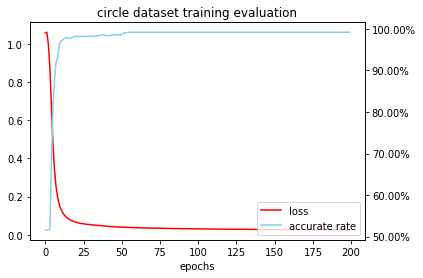

In [6]:
# graph of 'loss' and 'accuracy'
loss_val = list(zip(*loss_val))
acc_val = list(zip(*acc_val))
import matplotlib.ticker as ticker
import numpy as np
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.array(loss_val[0]), np.array(loss_val[1]), "-r", label="loss")
ax2.plot(np.array(acc_val[0]), np.array(acc_val[1])*100, color="skyblue", label="accurate rate")
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f%%"))
ax1.set_xlabel("epochs")
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles1+handles2, labels1+labels2)
plt.title("circle dataset training evaluation")
plt.show()

## 4.测试集上的表现
&emsp;&emsp;重新生成200个样本作为测试集数据，在训练集上对参数进行优化，并分别计算在训练集和测试集上的损失函数、准确率。

In [12]:
X_test = tf.placeholder(shape=(None, 2), dtype=tf.float32, name="test_input")
Y_test = tf.placeholder(shape=(None, 1), dtype=tf.float32, name="test_label")
num_test_samples = 200
test_data, test_label = dataset.get_samples(dataset.classify_circle_data, num_test_samples, noise, False)
loss_val = []
acc_val = []
loss_val_test = []
acc_val_test = []
with tf.Session() as sess2:
    sess2.run(init)
    print("Model 1: Circle data")
    for epoch in range(n_epochs):
        for itr in range(n_iters):
            X_batch = data[itr*batch_size:(itr+1)*batch_size, :]
            Y_batch = label[itr*batch_size:(itr+1)*batch_size, :]
            sess2.run(training_op, feed_dict={X: X_batch, Y: Y_batch})
        l, acc = sess2.run([loss, accuracy], feed_dict={X: data, Y: label})
        l_test, acc_test = sess2.run([loss, accuracy], feed_dict={X: test_data, Y: test_label})
        loss_val.append([epoch, l])
        acc_val.append([epoch, acc])
        loss_val_test.append([epoch, l_test])
        acc_val_test.append([epoch, acc_test])
        if not (epoch % 10):
            preds = sess2.run(pred_y, feed_dict={X: data, Y: label})
            print("Epoch:{}\nPrediction:\n{}, \nTrue label:\n{},"
                  " \nLoss:{:.3f}, \nAccuracy:{:.2%}".format(epoch, preds[::50], label[::50], l, acc))


Model 1: Circle data
Epoch:0
Prediction:
[[-0.28822413]
 [-0.27827302]
 [-0.36916509]
 [-0.37736443]
 [-0.37048301]
 [-0.3565084 ]
 [-0.24891016]
 [-0.25156406]
 [-0.25245023]
 [-0.30459464]], 
True label:
[[ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]], 
Loss:1.080, 
Accuracy:51.60%
Epoch:10
Prediction:
[[ 0.30740854]
 [ 0.82510734]
 [ 0.47864339]
 [-0.26799962]
 [ 0.5970757 ]
 [-0.8817988 ]
 [-0.79633397]
 [-0.76876456]
 [-0.78401107]
 [-0.85119903]], 
True label:
[[ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]], 
Loss:0.187, 
Accuracy:95.00%
Epoch:20
Prediction:
[[ 0.81211472]
 [ 0.98349464]
 [ 0.85459322]
 [-0.04011006]
 [ 0.91363829]
 [-0.89464086]
 [-0.9440012 ]
 [-0.91983163]
 [-0.89955652]
 [-0.94567847]], 
True label:
[[ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]], 
Loss:0.063, 
Accuracy:98.20%
Epoch:30
Prediction:
[[ 0.90498114]
 [ 0.99454778]
 [ 0.9145897 ]
 [-0.02481577]
 [ 0.95554715]
 [-0.92764616]
 [-0.96862489]
 [-0.95013267]
 [-0.

Text(0.5, 1.0, 'accuracy rate on training and test set')

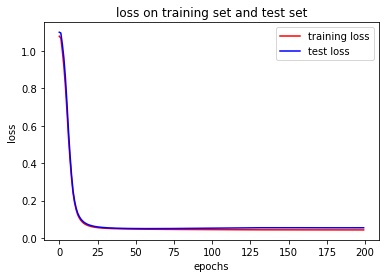

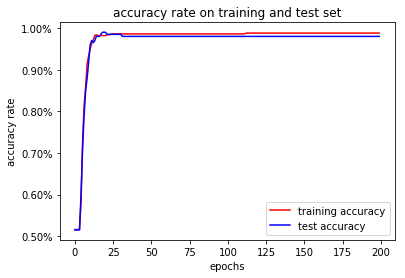

In [13]:
loss_val = list(zip(*loss_val))
acc_val = list(zip(*acc_val))
loss_val_test = list(zip(*loss_val_test))
acc_val_test = list(zip(*acc_val_test))
plt.figure(1)
plt.plot(np.array(loss_val[0]), np.array(loss_val[1]), color="red", label="training loss")
plt.plot(np.array(loss_val_test[0]), np.array(loss_val_test[1]), color="blue",label="test loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("loss on training set and test set")
plt.legend()

plt.figure(2)
ax = plt.gca()
plt.plot(np.array(acc_val[0]), np.array(acc_val[1])*100, color="red", label="training accuracy")
plt.plot(np.array(acc_val_test[0]), np.array(acc_val_test[1])*100, color="blue",label="test accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy rate")
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f%%"))
plt.legend()
plt.title("accuracy rate on training and test set")

&emsp;&emsp;模型训练集和测试集上的表现还是比较相近的，在200个epoch内没有出现明显的过拟合现象。

&emsp;&emsp;下面来看一下增加样本量，表现会有什么不同。

## 5.大样本下的表现
&emsp;&emsp;之前我们采用样本量500的训练集和样本量200的测试集。现在我们扩大样本量分别为5,000和1,000。同时采用较大的batch size和较大的噪声，其余参数保持不变，再看一下模型的训练效果。

Model 1: Circle data


Text(0.5, 1.0, 'accuracy rate on training and test set')

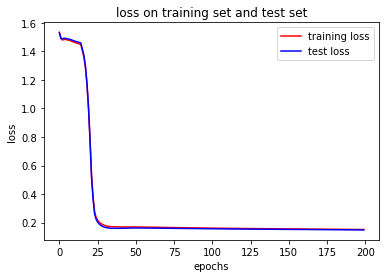

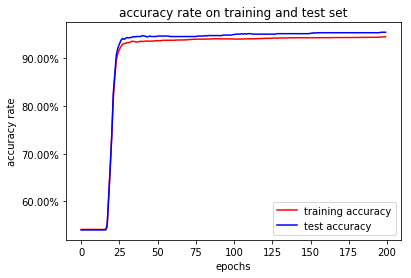

In [16]:
num_samples = 5000
noise = 0.15
num_test_samples = 1000
data, label = dataset.get_samples(dataset.classify_circle_data, num_samples, noise, False)
test_data, test_label = dataset.get_samples(dataset.classify_circle_data, num_test_samples, noise, False)
num = data.shape[0]
batch_size = 50
# 每个epoch执行mini-batch的次数
n_iters = num // batch_size
loss_val = []
acc_val = []
loss_val_test = []
acc_val_test = []
with tf.Session() as sess2:
    sess2.run(init)
    print("Model 1: Circle data")
    for epoch in range(n_epochs):
        for itr in range(n_iters):
            X_batch = data[itr*batch_size:(itr+1)*batch_size, :]
            Y_batch = label[itr*batch_size:(itr+1)*batch_size, :]
            sess2.run(training_op, feed_dict={X: X_batch, Y: Y_batch})
        l, acc = sess2.run([loss, accuracy], feed_dict={X: data, Y: label})
        l_test, acc_test = sess2.run([loss, accuracy], feed_dict={X: test_data, Y: test_label})
        loss_val.append([epoch, l])
        acc_val.append([epoch, acc])
        loss_val_test.append([epoch, l_test])
        acc_val_test.append([epoch, acc_test])
#         if not (epoch % 10):
#             preds = sess2.run(pred_y, feed_dict={X: data, Y: label})
#             print("Epoch:{}\nPrediction:\n{}, \nTrue label:\n{},"
#                   " \nLoss:{:.3f}, \nAccuracy:{:.2%}".format(epoch, preds[::500], label[::500], l, acc))
loss_val = list(zip(*loss_val))
acc_val = list(zip(*acc_val))
loss_val_test = list(zip(*loss_val_test))
acc_val_test = list(zip(*acc_val_test))
plt.figure(1)
plt.plot(np.array(loss_val[0]), np.array(loss_val[1]), color="red", label="training loss")
plt.plot(np.array(loss_val_test[0]), np.array(loss_val_test[1]), color="blue",label="test loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("loss on training set and test set")
plt.legend()

plt.figure(2)
ax = plt.gca()
plt.plot(np.array(acc_val[0]), np.array(acc_val[1])*100, color="red", label="training accuracy")
plt.plot(np.array(acc_val_test[0]), np.array(acc_val_test[1])*100, color="blue",label="test accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy rate")
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f%%"))
plt.legend()
plt.title("accuracy rate on training and test set")

## 6.添加正则化项
&emsp;&emsp;常用的正则化仅对权重参数施加“惩罚”。以下在代价函数$J(\theta)$中添加$L_2$的惩罚项进行优化。

In [23]:
tf.reset_default_graph()
# get data from dataset module, which is
num_samples = 5000
noise = 0.1
data, label = dataset.get_samples(dataset.classify_circle_data, num_samples, noise, False)
num_test_samples = 1000
test_data, test_label = dataset.get_samples(dataset.classify_circle_data, num_test_samples, noise, False)
# define data in default graph
X = tf.placeholder(dtype=tf.float32, shape=(None, 2), name="input")
Y = tf.placeholder(dtype=tf.float32, shape=(None, 1), name="label")

# try two hidden layers with 4 nodes each(3 layers in total)
# number of nodes in hidden layer 1
n_hidden1 = 3
# number of nodes in hidden layer 2
n_hidden2 = 3
# number of output
n_output = 1
#regularization_rate
reg_rate = 0.03

with tf.name_scope("dnn_circle"):
    # l2_regularization
    hidden1 = fully_connected(X, n_hidden1, tf.nn.relu, scope="hidden1",
                             weights_initializer=tf.random_uniform_initializer(minval=-0.5, maxval=0.5),
                             biases_initializer=tf.constant_initializer(0.1),
                             weights_regularizer=l2_regularizer(scale=reg_rate))
    hidden2 = fully_connected(hidden1, n_hidden2, tf.nn.relu, scope="hidden2",
                             weights_initializer=tf.random_uniform_initializer(minval=-0.5, maxval=0.5),
                             biases_initializer=tf.constant_initializer(0.1),
                             weights_regularizer=l2_regularizer(scale=reg_rate))
    pred_y = fully_connected(hidden2, n_output, scope="output", activation_fn=tf.nn.tanh,
                             weights_initializer=tf.random_uniform_initializer(minval=-0.5, maxval=0.5),
                             biases_initializer=tf.constant_initializer(0.1),
                             weights_regularizer=l2_regularizer(scale=reg_rate))

with tf.name_scope("loss"):
    reg_ws = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES, 'dnn_circle')
    # pred_y输出（？，1）维度，如果Y或label与其维度不同会导致loss计算错误
    loss = tf.reduce_mean(tf.square(pred_y - Y), name="loss") + tf.reduce_sum(reg_ws)

# 学习率
learning_rate = 0.05
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

# 以准确率作为评价标准
with tf.name_scope("eval"):
    # 分类标准，pred_y>0.则分类为1；反之分类为0
    # 为输出拼接上一列全为0的向量，如果原输出为[0.98]，现在concat后为[0.,0.98]
    concat_preds = tf.concat([tf.zeros_like(pred_y, tf.float32), pred_y], axis=1)
    # 判断0.与原输出较大者的下标（0或1），并与真实的标签对比
    # 注：这里要求被对比的标签是1维的，所以用tf.squeeze降维
    #     且由于标签是-1和1，而下标是0或1，因此需要tf.clip_by_value将标签变为0~1
    correct = tf.nn.in_top_k(concat_preds,
                                 tf.cast(tf.clip_by_value(tf.squeeze(Y, [1]), 0., 1.), tf.int32), 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
batch_size = 50
n_epochs = 300

Model 1: Circle data


Text(0.5, 1.0, 'accuracy rate on training and test set')

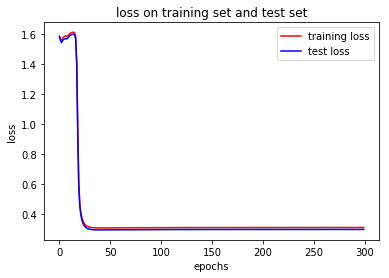

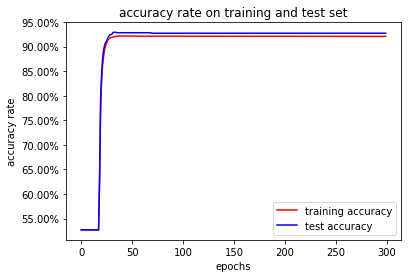

In [24]:
num = data.shape[0]
# 每个epoch执行mini-batch的次数
n_iters = num // batch_size
loss_val = []
acc_val = []
loss_val_test = []
acc_val_test = []
with tf.Session() as sess2:
    sess2.run(init)
    print("Model 1: Circle data")
    for epoch in range(n_epochs):
        for itr in range(n_iters):
            X_batch = data[itr*batch_size:(itr+1)*batch_size, :]
            Y_batch = label[itr*batch_size:(itr+1)*batch_size, :]
            sess2.run(training_op, feed_dict={X: X_batch, Y: Y_batch})
        l, acc = sess2.run([loss, accuracy], feed_dict={X: data, Y: label})
        l_test, acc_test = sess2.run([loss, accuracy], feed_dict={X: test_data, Y: test_label})
        loss_val.append([epoch, l])
        acc_val.append([epoch, acc])
        loss_val_test.append([epoch, l_test])
        acc_val_test.append([epoch, acc_test])
#         if not (epoch % 10):
#             preds = sess2.run(pred_y, feed_dict={X: data, Y: label})
#             print("Epoch:{}\nPrediction:\n{}, \nTrue label:\n{},"
#                   " \nLoss:{:.3f}, \nAccuracy:{:.2%}".format(epoch, preds[::500], label[::500], l, acc))
loss_val = list(zip(*loss_val))
acc_val = list(zip(*acc_val))
loss_val_test = list(zip(*loss_val_test))
acc_val_test = list(zip(*acc_val_test))
plt.figure(1)
plt.plot(np.array(loss_val[0]), np.array(loss_val[1]), color="red", label="training loss")
plt.plot(np.array(loss_val_test[0]), np.array(loss_val_test[1]), color="blue",label="test loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("loss on training set and test set")
plt.legend()

plt.figure(2)
ax = plt.gca()
plt.plot(np.array(acc_val[0]), np.array(acc_val[1])*100, color="red", label="training accuracy")
plt.plot(np.array(acc_val_test[0]), np.array(acc_val_test[1])*100, color="blue",label="test accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy rate")
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f%%"))
plt.legend()
plt.title("accuracy rate on training and test set")

&emsp;&emsp;可以看到，正则化的效果并不是很好（loss升高，accuracy降低），因为原本在训练过程中过拟合现象并不明显；以及，我们的模型复杂度相对于样本量也并不大。此时可以不需要正则化，或者正则率regularization_rate可以取比较小的值。